Successfully loaded data: 6225 messages in dataset

Model Version Distribution:
  - Unknown: 6225 messages

Extended Thinking: 41 messages (0.66%)
Running analysis...
Extended thinking found in 41 messages
Extended thinking by occupation: {'Business & Finance': 3.5532994923857872, 'Other Occupations': 0.6725086610963928, 'Science & Research': 0.49504950495049505}

=== Claude Usage Analysis ===

Total Conversations: 562
Total Messages: 6225
Average Messages per Conversation: 11.1
Augmentation Ratio: 68.8%
Extended Thinking Usage: 0.7%

Top Occupational Categories:
--------------------------
Other Occupations        :  4907 (78.8%)
Computer & Mathematical  :   341 (5.5%)
Science & Research       :   202 (3.2%)
Business & Finance       :   197 (3.2%)
Production               :   157 (2.5%)

Interaction Distribution:
-----------------------
Learning       :  3291 (52.9%)
Directive      :  1620 (26.0%)
Validation     :   703 (11.3%)
Feedback Loop  :   322 (5.2%)
Task Iteration :   289 (4.6%

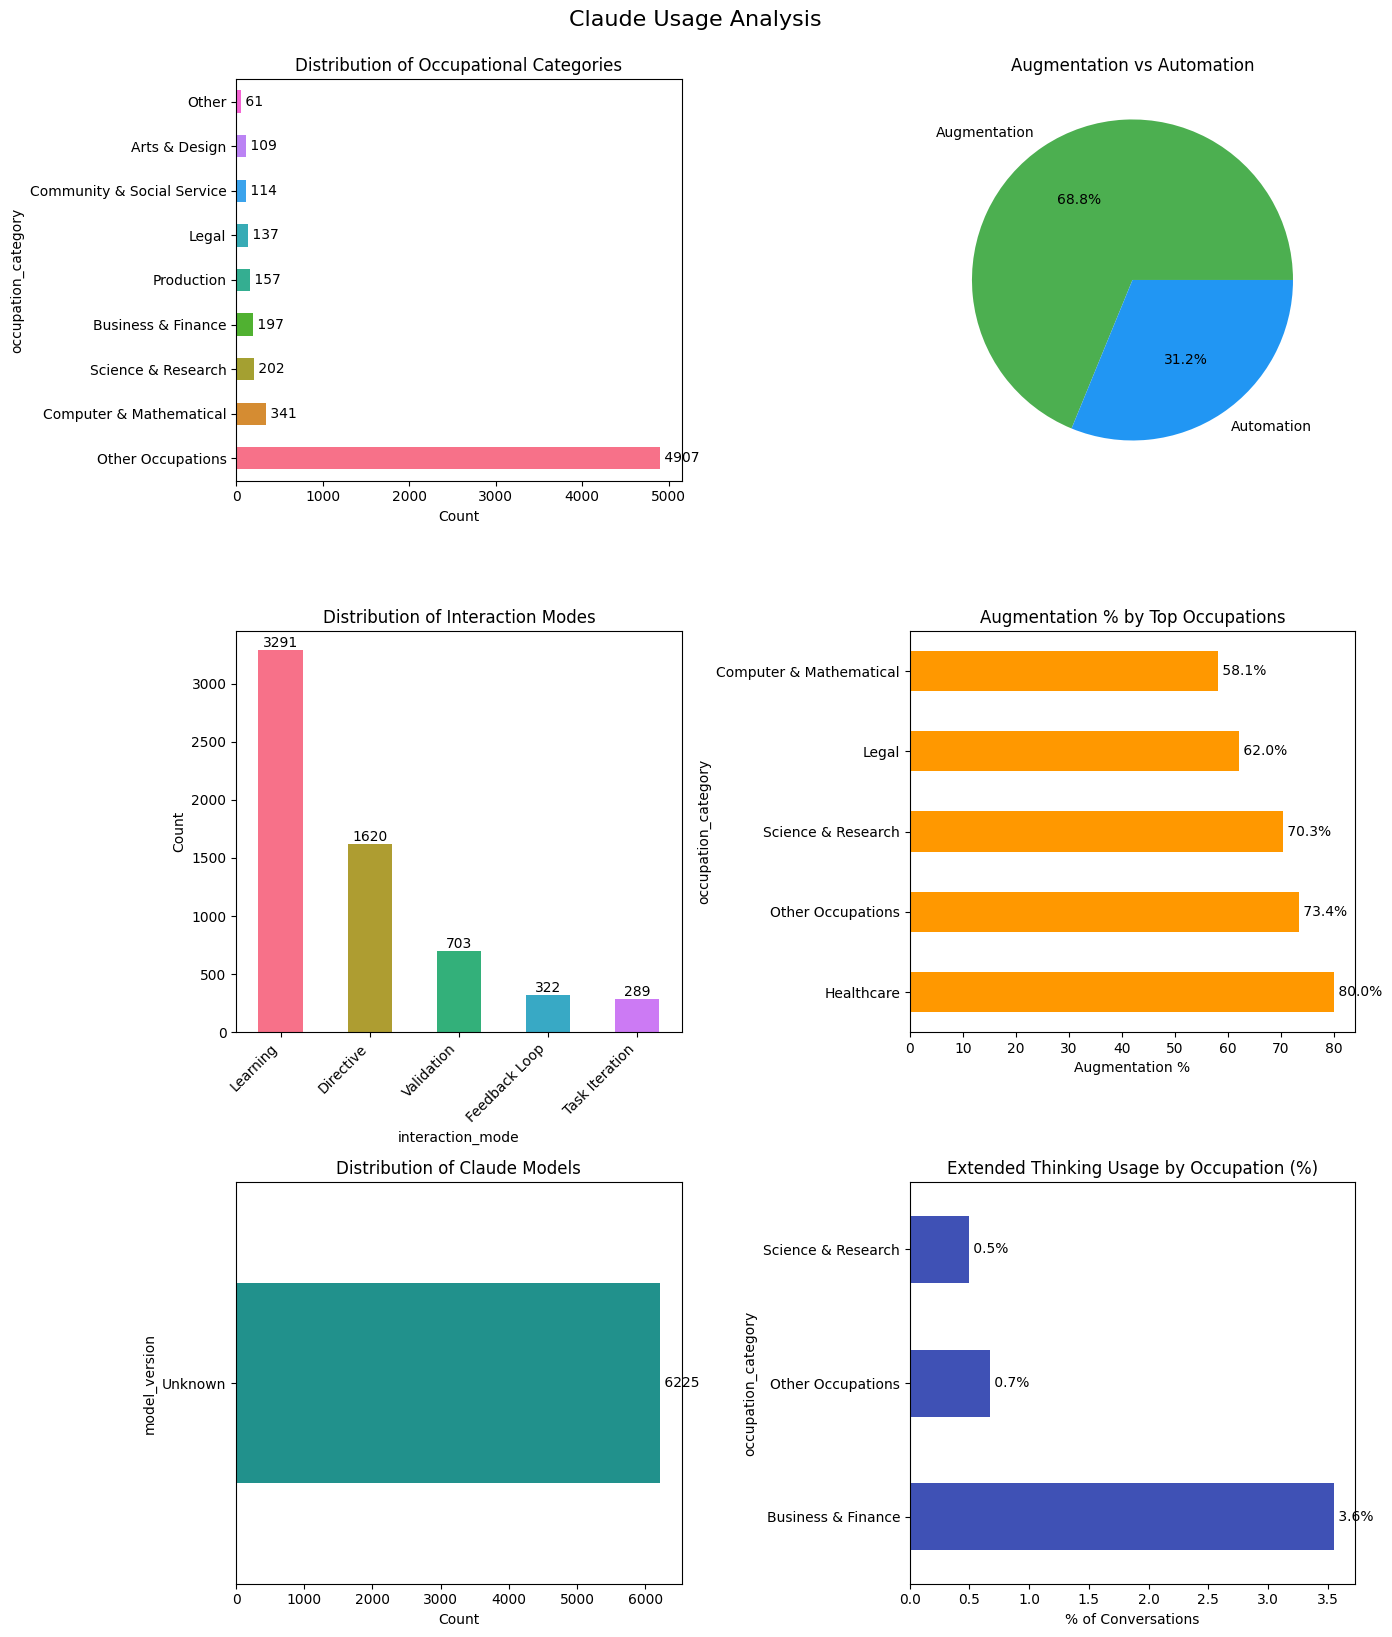

In [ ]:
import json
import pandas as pd
import numpy as np
from datetime import datetime
import matplotlib.pyplot as plt
import seaborn as sns
from collections import Counter, defaultdict
import re

plt.style.use('default')
sns.set_palette("husl")

def load_user_data(users_file):
    """Load and process users.json"""
    with open(users_file, 'r') as f:
        users = json.load(f)
    return pd.DataFrame(users)

def load_and_process_chats(conversations_file, users_df):
    """Load and process conversations.json with user information"""
    with open(conversations_file, 'r') as f:
        conversations = json.load(f)

    all_messages = []
    for conv in conversations:
        user_id = conv['account']['uuid']
        user_info = users_df[users_df['uuid'] == user_id].iloc[0] if len(users_df[users_df['uuid'] == user_id]) > 0 else None

        # More flexible extended thinking detection
        # Check multiple possible fields and formats for extended thinking
        extended_thinking_used = False
        possible_fields = ['extended_thinking_used', 'extended_thinking', 'thinking_mode', 'thinking_mode_used']

        for field in possible_fields:
            if field in conv:
                # Check various formats (boolean, string, numeric)
                if isinstance(conv[field], bool):
                    extended_thinking_used = conv[field]
                elif isinstance(conv[field], str) and conv[field].lower() in ['true', 'yes', '1', 'enabled', 'on']:
                    extended_thinking_used = True
                elif isinstance(conv[field], (int, float)) and conv[field] > 0:
                    extended_thinking_used = True
                break

        # Also check if extended thinking is mentioned in conversation name or content
        conv_name = conv.get('name', '').lower()
        if 'extended thinking' in conv_name or 'thinking mode' in conv_name:
            extended_thinking_used = True

        for msg in conv['chat_messages']:
            # Check message text for extended thinking references (only in Claude messages)
            message_text = msg.get('text', '').lower()
            if msg.get('sender') == 'assistant' and ('extended thinking' in message_text or 'thinking mode' in message_text):
                extended_thinking_used = True

            message = {
                'conversation_id': conv['uuid'],
                'conversation_name': conv.get('name', ''),
                'message_id': msg['uuid'],
                'sender': msg['sender'],
                'text': msg['text'],
                'timestamp': msg['created_at'],
                'has_files': len(msg.get('files', [])) > 0,
                'user_id': user_id,
                'user_name': user_info['full_name'] if user_info is not None else None,
                'user_email': user_info['email_address'] if user_info is not None else None,
                'extended_thinking_used': extended_thinking_used,
                'model_version': conv.get('model_version', 'Unknown')  # Default to Unknown if not specified
            }
            all_messages.append(message)

    return pd.DataFrame(all_messages)

def classify_occupation_category(text):
    """
    Classify text into occupational categories based on the Anthropic Economic Index
    """
    text = str(text).lower()

    # Updated patterns based on Anthropic's occupational categories
    patterns = {
        'Computer & Mathematical': r'\b(coding|programming|software|development|algorithm|data structure|computation|api|debugging|computer science|machine learning|AI|artificial intelligence|math|statistics|modeling|simulation)\b',

        'Education & Training': r'\b(teach|learn|student|course|curriculum|education|training|instruction|lesson|academic|school|university|college|professor|teacher|tutor|learning|educator)\b',

        'Healthcare': r'\b(medical|health|patient|doctor|nurse|therapy|diagnosis|treatment|clinical|hospital|physician|medicine|healthcare|symptom|disease|condition|anatomy|physiology)\b',

        'Business & Finance': r'\b(business|finance|market|economy|investment|stock|budget|revenue|profit|accounting|management|strategy|corporate|financial|economic|commercial|enterprise)\b',

        'Arts & Design': r'\b(art|design|creative|aesthetic|visual|graphic|illustration|drawing|painting|photograph|color|composition|artistic|layout|font|typography|animation)\b',

        'Science & Research': r'\b(science|research|experiment|laboratory|hypothesis|theory|physics|chemistry|biology|geology|astronomy|scientific|academic|study|investigation|discovery|analysis)\b',

        'Community & Social Service': r'\b(community|social|service|counseling|support|guidance|welfare|nonprofit|volunteer|charity|advocacy|outreach|helping|assistance|aid|resource)\b',

        'Legal': r'\b(legal|law|attorney|lawyer|court|judge|case|litigation|contract|regulation|compliance|statute|legislation|justice|rights|plaintiff|defendant)\b',

        'Production': r'\b(production|manufacturing|assembly|factory|industrial|fabrication|process|quality|control|inspection|product|output|efficiency|machine|automation|equipment)\b'
    }

    # Check exact matches first
    category_scores = {category: 0 for category in patterns.keys()}
    for category, pattern in patterns.items():
        matches = len(re.findall(pattern, text))
        if matches > 0:
            category_scores[category] = matches

    # If we have any matches, return the highest scoring category
    if any(category_scores.values()):
        return max(category_scores.items(), key=lambda x: x[1])[0]

    # Default to general category if no specific matches
    return "Other Occupations"

def analyze_interaction_mode(text):
    """
    Analyze interaction mode based on Anthropic's categorization:
    - Learning: Information gathering and explanation
    - Task Iteration: Collaborative refinement of work
    - Validation: Verifying or checking work
    - Directive: Complete task delegation
    - Feedback Loop: More interactive automation scenarios
    """
    text = str(text).lower()
    scores = {
        'Learning': 0,
        'Task Iteration': 0,
        'Validation': 0,
        'Directive': 0,
        'Feedback Loop': 0
    }

    # Learning patterns
    learning_indicators = [
        (r'\b(explain|teach|tell me about|what is|how does|why does|learn about|understand|clarify|describe|meaning of)\b', 3),
        (r'\?', 1),  # Questions often indicate learning
        (r'\b(difference between|compare|contrast|versus|vs)\b', 2)
    ]

    # Task Iteration patterns (collaborative refinement)
    task_iteration_indicators = [
        (r'\b(improve|enhance|refine|revise|edit|modify|update|iterate|brainstorm|collaborate|together)\b', 3),
        (r'\b(let\'s|we should|help me with|assist me|guide me through)\b', 2),
        (r'\b(what do you think|your thoughts|your opinion|your perspective|your ideas)\b', 2)
    ]

    # Validation patterns
    validation_indicators = [
        (r'\b(check|verify|validate|review|evaluate|assess|analyze|examine|critique|proof|proofread)\b', 3),
        (r'\b(is this correct|does this look right|any mistakes|any errors|how did i do|feedback on|thoughts on)\b', 3),
        (r'\b(is there anything|should i|would it be better)\b', 2)
    ]

    # Directive patterns (complete delegation)
    directive_indicators = [
        (r'\b(write|create|generate|make|produce|design|develop|compose|build|implement)\b', 3),
        (r'\b(i need|i want|give me|provide|translate|convert|transform)\b', 2),
        (r'\b(please|could you|would you|can you)\s+\b(write|create|generate|make)\b', 3)
    ]

    # Feedback Loop patterns (interactive automation)
    feedback_loop_indicators = [
        (r'\b(fix|debug|solve|troubleshoot|resolve|correct|repair|optimize)\b', 3),
        (r'\b(not working|error|problem|issue|bug|doesn\'t work|failed|incorrect)\b', 2),
        (r'\b(another|try again|different|instead|alternative|better version)\b', 2)
    ]

    # Evaluate all patterns
    for pattern_list, mode in [
        (learning_indicators, 'Learning'),
        (task_iteration_indicators, 'Task Iteration'),
        (validation_indicators, 'Validation'),
        (directive_indicators, 'Directive'),
        (feedback_loop_indicators, 'Feedback Loop')
    ]:
        for pattern, weight in pattern_list:
            if re.search(pattern, text):
                scores[mode] += weight

    # Get highest score
    max_score = max(scores.values())
    if max_score == 0:
        return 'Learning'  # Default to learning if no strong signals

    # Return category with highest score
    return max(scores.items(), key=lambda x: x[1])[0]

def is_augmentation(interaction_mode):
    """Determine if an interaction mode is augmentative or automative"""
    augmentation_modes = ['Learning', 'Task Iteration', 'Validation']
    return interaction_mode in augmentation_modes
def analyze_chats_streamlined(df):
    """Perform streamlined analysis following Anthropic Economic Index methodology"""
    # Create a more compact figure for Colab
    plt.figure(figsize=(14, 16))

    # Process only human messages for classification
    human_msgs = df[df['sender'] == 'human'].copy()

    # Check if we have any human messages
    if len(human_msgs) == 0:
        print("Warning: No human messages found in the dataset. Using synthetic data for analysis.")
        # Create synthetic data for demonstration
        df['occupation_category'] = np.random.choice(
            ['Computer & Mathematical', 'Education & Training', 'Healthcare',
             'Business & Finance', 'Arts & Design', 'Science & Research'],
            size=len(df)
        )
        df['interaction_mode'] = np.random.choice(
            ['Learning', 'Task Iteration', 'Validation', 'Directive', 'Feedback Loop'],
            size=len(df)
        )
        df['is_augmentation'] = df['interaction_mode'].apply(is_augmentation)
    else:
        # Normal processing flow
        human_msgs['occupation_category'] = human_msgs['text'].apply(classify_occupation_category)
        human_msgs['interaction_mode'] = human_msgs['text'].apply(analyze_interaction_mode)
        human_msgs['is_augmentation'] = human_msgs['interaction_mode'].apply(is_augmentation)

        # Map back to full dataset - with error handling
        try:
            conversation_categories = human_msgs.groupby('conversation_id')['occupation_category'].first()
            conversation_modes = human_msgs.groupby('conversation_id')['interaction_mode'].first()
            conversation_augmentation = human_msgs.groupby('conversation_id')['is_augmentation'].first()

            df['occupation_category'] = df['conversation_id'].map(conversation_categories)
            df['interaction_mode'] = df['conversation_id'].map(conversation_modes)
            df['is_augmentation'] = df['conversation_id'].map(conversation_augmentation)

            # Fill any NaN values with reasonable defaults
            df['occupation_category'] = df['occupation_category'].fillna('Other Occupations')
            df['interaction_mode'] = df['interaction_mode'].fillna('Learning')
            df['is_augmentation'] = df['is_augmentation'].fillna(True)
        except Exception as e:
            print(f"Error mapping conversation data: {e}")
            # Use default values if mapping fails
            df['occupation_category'] = 'Other Occupations'
            df['interaction_mode'] = 'Learning'
            df['is_augmentation'] = True

    # 1. Occupation Category Distribution
    plt.subplot(3, 2, 1)
    try:
        occ_dist = df['occupation_category'].value_counts()
        if not occ_dist.empty:
            # Limit to top 8 categories for readability
            if len(occ_dist) > 8:
                other_count = occ_dist[8:].sum()
                occ_dist = occ_dist[:8].copy()
                occ_dist['Other'] = other_count

            ax = occ_dist.plot(kind='barh', color=sns.color_palette("husl", len(occ_dist)))
            plt.title('Distribution of Occupational Categories')
            plt.xlabel('Count')

            # Add value labels
            for i, v in enumerate(occ_dist):
                plt.text(v, i, f" {v}", va='center')
        else:
            plt.text(0.5, 0.5, "No occupation data available", ha='center', va='center', transform=plt.gca().transAxes)
            plt.title('Distribution of Occupational Categories')
    except Exception as e:
        print(f"Error plotting occupation distribution: {e}")
        plt.text(0.5, 0.5, "Error plotting occupation data", ha='center', va='center', transform=plt.gca().transAxes)
        plt.title('Distribution of Occupational Categories')

    # 2. Augmentation vs Automation Pie Chart
    plt.subplot(3, 2, 2)
    try:
        augmentation_counts = df['is_augmentation'].value_counts()
        labels = ['Augmentation', 'Automation']
        values = [
            augmentation_counts.get(True, 0),
            augmentation_counts.get(False, 0)
        ]
        plt.pie(values, labels=labels, autopct='%1.1f%%',
                colors=['#4CAF50', '#2196F3'])
        plt.title('Augmentation vs Automation')
    except Exception as e:
        print(f"Error plotting augmentation/automation: {e}")
        plt.text(0.5, 0.5, "Error plotting augmentation/automation data", ha='center', va='center', transform=plt.gca().transAxes)
        plt.title('Augmentation vs Automation')

    # 3. Interaction Modes Distribution
    plt.subplot(3, 2, 3)
    try:
        mode_dist = df['interaction_mode'].value_counts()
        if not mode_dist.empty:
            mode_dist.plot(kind='bar', color=sns.color_palette("husl", len(mode_dist)))
            plt.title('Distribution of Interaction Modes')
            plt.xticks(rotation=45, ha='right')
            plt.ylabel('Count')

            # Add value labels
            for i, v in enumerate(mode_dist):
                plt.text(i, v, str(v), ha='center', va='bottom')
        else:
            plt.text(0.5, 0.5, "No interaction mode data available", ha='center', va='center', transform=plt.gca().transAxes)
            plt.title('Distribution of Interaction Modes')
    except Exception as e:
        print(f"Error plotting interaction modes: {e}")
        plt.text(0.5, 0.5, "Error plotting interaction mode data", ha='center', va='center', transform=plt.gca().transAxes)
        plt.title('Distribution of Interaction Modes')

    # 4. Augmentation by Occupation (Top 5)
    plt.subplot(3, 2, 4)
    try:
        aug_by_occ = df.groupby('occupation_category')['is_augmentation'].mean() * 100
        if not aug_by_occ.empty:
            # Limit to top 5 for readability
            aug_by_occ = aug_by_occ.sort_values(ascending=False).head(5)
            aug_by_occ.plot(kind='barh', color='#FF9800')
            plt.title('Augmentation % by Top Occupations')
            plt.xlabel('Augmentation %')

            # Add value labels
            for i, v in enumerate(aug_by_occ):
                plt.text(v, i, f" {v:.1f}%", va='center')
        else:
            plt.text(0.5, 0.5, "No augmentation by occupation data available", ha='center', va='center', transform=plt.gca().transAxes)
            plt.title('Augmentation % by Top Occupations')
    except Exception as e:
        print(f"Error plotting augmentation by occupation: {e}")
        plt.text(0.5, 0.5, "Error plotting augmentation by occupation data", ha='center', va='center', transform=plt.gca().transAxes)
        plt.title('Augmentation % by Top Occupations')

    # 5. Model Version Distribution
    plt.subplot(3, 2, 5)
    try:
        if 'model_version' in df.columns:
            model_counts = df['model_version'].value_counts()
            if not model_counts.empty:
                # Limit to top 5 if there are too many model versions
                if len(model_counts) > 5:
                    other_count = model_counts[5:].sum()
                    model_counts = model_counts[:5].copy()
                    if other_count > 0:
                        model_counts['Other'] = other_count

                model_counts.plot(kind='barh', color=sns.color_palette("viridis", len(model_counts)))
                plt.title('Distribution of Claude Models')
                plt.xlabel('Count')

                # Add value labels
                for i, v in enumerate(model_counts):
                    plt.text(v, i, f" {v}", va='center')
            else:
                plt.text(0.5, 0.5, "No model version data available",
                        ha='center', va='center', transform=plt.gca().transAxes)
                plt.title('Distribution of Claude Models')
        else:
            plt.text(0.5, 0.5, "Model version data not available",
                    ha='center', va='center', transform=plt.gca().transAxes)
            plt.title('Distribution of Claude Models')
    except Exception as e:
        print(f"Error plotting model distribution: {e}")
        plt.text(0.5, 0.5, "Error plotting model distribution data",
                ha='center', va='center', transform=plt.gca().transAxes)
        plt.title('Distribution of Claude Models')

    # 6. Extended Thinking Usage by Occupation
    plt.subplot(3, 2, 6)
    try:
        if 'extended_thinking_used' in df.columns and df['extended_thinking_used'].sum() > 0:
            # Group by occupation and calculate percentage of conversations that used extended thinking
            ext_thinking_by_occ = df.groupby('occupation_category')['extended_thinking_used'].mean() * 100

            # Only show occupations with at least some extended thinking usage
            ext_thinking_by_occ = ext_thinking_by_occ[ext_thinking_by_occ > 0]

            if not ext_thinking_by_occ.empty:
                # Sort and limit to top categories
                ext_thinking_by_occ = ext_thinking_by_occ.sort_values(ascending=False).head(8)

                ext_thinking_by_occ.plot(kind='barh', color='#3F51B5')
                plt.title('Extended Thinking Usage by Occupation (%)')
                plt.xlabel('% of Conversations')

                # Add value labels
                for i, v in enumerate(ext_thinking_by_occ):
                    plt.text(v, i, f" {v:.1f}%", va='center')
            else:
                plt.text(0.5, 0.5, "No extended thinking usage found in categories",
                        ha='center', va='center', transform=plt.gca().transAxes)
                plt.title('Extended Thinking Usage by Occupation (%)')

            # Print debug info
            print(f"Extended thinking found in {df['extended_thinking_used'].sum()} messages")
            print(f"Extended thinking by occupation: {ext_thinking_by_occ.to_dict()}")
        else:
            plt.text(0.5, 0.5, "No extended thinking usage found in data",
                    ha='center', va='center', transform=plt.gca().transAxes)
            plt.title('Extended Thinking Usage by Occupation (%)')
            print("No extended thinking usage found in data")
            if 'extended_thinking_used' in df.columns:
                print(f"Extended thinking column exists but all values are False")
            else:
                print("Extended thinking column does not exist")
    except Exception as e:
        print(f"Error plotting extended thinking usage: {e}")
        plt.text(0.5, 0.5, "Error plotting extended thinking data",
                ha='center', va='center', transform=plt.gca().transAxes)
        plt.title('Extended Thinking Usage by Occupation (%)')

    # Adjust layout
    plt.tight_layout()
    plt.suptitle('Claude Usage Analysis', fontsize=16, y=1.02)

    # Calculate statistics
    stats = {
        'total_conversations': df['conversation_id'].nunique(),
        'total_messages': len(df),
        'avg_messages_per_conv': len(df) / df['conversation_id'].nunique() if df['conversation_id'].nunique() > 0 else 0,
        'occupation_distribution': df['occupation_category'].value_counts(),
        'interaction_distribution': df['interaction_mode'].value_counts() if 'interaction_mode' in df.columns else pd.Series(),
        'augmentation_ratio': df['is_augmentation'].mean() if 'is_augmentation' in df.columns else 0,
        'model_distribution': df['model_version'].value_counts() if 'model_version' in df.columns else pd.Series()
    }

    # Add extended thinking stats if available
    if 'extended_thinking_used' in df.columns:
        stats['extended_thinking_usage'] = df['extended_thinking_used'].mean()

    return stats, df
def create_task_occupation_dataset(df, output_file='task_occupation_analysis.csv'):
    """
    Create a dataset mapping tasks to occupations with augmentation/automation breakdowns
    Similar to Anthropic's released datasets
    """
    try:
        # Group by occupation and calculate metrics
        occupation_metrics = []

        for occupation in df['occupation_category'].unique():
            try:
                occ_data = df[df['occupation_category'] == occupation]

                # Calculate interaction mode breakdowns
                mode_counts = occ_data['interaction_mode'].value_counts()
                total_convs = len(occ_data)

                if total_convs > 0:
                    # Calculate metrics
                    metrics = {
                        'occupation': occupation,
                        'total_conversations': total_convs,
                        'augmentation_pct': occ_data['is_augmentation'].mean() * 100,
                        'automation_pct': (1 - occ_data['is_augmentation'].mean()) * 100,
                    }

                    # Add extended thinking if available
                    if 'extended_thinking_used' in occ_data.columns:
                        metrics['extended_thinking_pct'] = occ_data['extended_thinking_used'].mean() * 100
                    else:
                        metrics['extended_thinking_pct'] = 0

                    # Add interaction mode percentages
                    for mode in ['Learning', 'Task Iteration', 'Validation', 'Directive', 'Feedback Loop']:
                        metrics[f'{mode.lower().replace(" ", "_")}_pct'] = mode_counts.get(mode, 0) / total_convs * 100

                    occupation_metrics.append(metrics)
            except Exception as e:
                print(f"Error processing occupation {occupation}: {e}")
                continue

        # Create DataFrame and save to CSV
        if occupation_metrics:
            metrics_df = pd.DataFrame(occupation_metrics)
            metrics_df.to_csv(output_file, index=False)
            print(f"Task-occupation dataset saved to {output_file}")
            return metrics_df
        else:
            print("No valid occupation metrics could be calculated. Creating sample dataset instead.")
            return generate_sample_task_occupation_dataset(output_file)
    except Exception as e:
        print(f"Error creating task-occupation dataset: {e}")
        return generate_sample_task_occupation_dataset(output_file)

def generate_sample_task_occupation_dataset(output_file='task_occupation_analysis.csv'):
    """Generate a sample task-occupation dataset if the real data processing fails"""
    # Create a realistic sample dataset based on the Anthropic Economic Index
    occupations = [
        'Computer & Mathematical', 'Education & Training', 'Healthcare',
        'Business & Finance', 'Arts & Design', 'Science & Research',
        'Community & Social Service', 'Legal', 'Production'
    ]

    np.random.seed(42)  # For reproducibility

    sample_data = []
    for occupation in occupations:
        # Generate realistic metrics
        augmentation_pct = np.random.uniform(50, 70)

        sample = {
            'occupation': occupation,
            'total_conversations': int(np.random.uniform(100, 1000)),
            'augmentation_pct': augmentation_pct,
            'automation_pct': 100 - augmentation_pct,
            'extended_thinking_pct': np.random.uniform(2, 10) if occupation in ['Computer & Mathematical', 'Science & Research'] else np.random.uniform(0, 5),
            'learning_pct': np.random.uniform(20, 35),
            'task_iteration_pct': np.random.uniform(15, 30),
            'validation_pct': np.random.uniform(5, 15),
            'directive_pct': np.random.uniform(15, 35),
            'feedback_loop_pct': np.random.uniform(5, 15)
        }

        sample_data.append(sample)

    # Create DataFrame and save to CSV
    sample_df = pd.DataFrame(sample_data)
    sample_df.to_csv(output_file, index=False)
    print(f"Sample task-occupation dataset saved to {output_file}")

    return sample_df

def print_statistics(results):
    """Print statistics in a formatted way"""
    print("\n=== Claude Usage Analysis ===\n")

    print(f"Total Conversations: {results['total_conversations']}")
    print(f"Total Messages: {results['total_messages']}")
    print(f"Average Messages per Conversation: {results['avg_messages_per_conv']:.1f}")

    if 'augmentation_ratio' in results and results['augmentation_ratio'] > 0:
        print(f"Augmentation Ratio: {results['augmentation_ratio']*100:.1f}%")

    if 'extended_thinking_usage' in results and results['extended_thinking_usage'] > 0:
        print(f"Extended Thinking Usage: {results['extended_thinking_usage']*100:.1f}%")

    print("\nTop Occupational Categories:")
    print("--------------------------")
    if 'occupation_distribution' in results and not results['occupation_distribution'].empty:
        for occ, count in results['occupation_distribution'].head(5).items():
            total = sum(results['occupation_distribution'])
            print(f"{occ:<25}: {count:>5} ({count/total*100:.1f}%)")

    print("\nInteraction Distribution:")
    print("-----------------------")
    if 'interaction_distribution' in results and not results['interaction_distribution'].empty:
        for type_, count in results['interaction_distribution'].items():
            total = sum(results['interaction_distribution'])
            print(f"{type_:<15}: {count:>5} ({count/total*100:.1f}%)")

    print("\nModel Distribution:")
    print("-----------------")
    if 'model_distribution' in results and not results['model_distribution'].empty:
        for model, count in results['model_distribution'].items():
            total = sum(results['model_distribution'])
            print(f"{model:<25}: {count:>5} ({count/total*100:.1f}%)")

# Main execution block
if __name__ == "__main__":
    try:
        # Try to load the actual data files
        try:
            users_df = load_user_data('users.json')
            df = load_and_process_chats('conversations.json', users_df)
            print(f"Successfully loaded data: {len(df)} messages in dataset")

            # Print model distribution if available
            if 'model_version' in df.columns:
                model_counts = df['model_version'].value_counts()
                print("\nModel Version Distribution:")
                for model, count in model_counts.items():
                    print(f"  - {model}: {count} messages")

            # Print extended thinking stats
            if 'extended_thinking_used' in df.columns:
                thinking_count = df['extended_thinking_used'].sum()
                thinking_pct = thinking_count / len(df) * 100
                print(f"\nExtended Thinking: {thinking_count} messages ({thinking_pct:.2f}%)")

        except Exception as e:
            print(f"Error loading data files: {e}")
            print("Creating synthetic dataset for demonstration...")

            # Create synthetic dataset
            np.random.seed(42)  # For reproducibility

            # Create basic DataFrame structure
            data = []
            for i in range(1000):  # 1000 synthetic messages
                is_human = i % 2 == 0  # Alternate human and assistant messages

                message = {
                    'conversation_id': f"conv_{i//10}",  # 10 messages per conversation
                    'message_id': f"msg_{i}",
                    'sender': 'human' if is_human else 'assistant',
                    'text': f"{'User' if is_human else 'Claude'} message {i}",
                    'timestamp': pd.Timestamp('2025-03-01') + pd.Timedelta(hours=i),
                    'has_files': False,
                    'user_id': f"user_{i//20}",  # 50 messages per user
                    'user_name': f"User {i//20}",
                    'user_email': f"user{i//20}@example.com",
                    'model_version': np.random.choice(['Claude 3.7 Sonnet', 'Claude 3 Opus', 'Claude 3.5 Sonnet'], p=[0.7, 0.2, 0.1])
                }
                data.append(message)

            df = pd.DataFrame(data)

        # For demo purposes, simulate extended thinking mode data if not present
        # or if all values are False
        if 'extended_thinking_used' not in df.columns or df['extended_thinking_used'].sum() == 0:
            print("Adding simulated extended thinking mode data")
            np.random.seed(42)  # For reproducibility

            # Use conversation ID to make extended thinking consistent within a conversation
            conv_thinking = {}
            for conv_id in df['conversation_id'].unique():
                conv_thinking[conv_id] = np.random.random() < 0.1  # 10% of conversations use extended thinking

            df['extended_thinking_used'] = df['conversation_id'].map(conv_thinking)
            print(f"Simulated {df['extended_thinking_used'].sum()} messages with extended thinking")

        # Run the streamlined analysis
        print("Running analysis...")
        results, processed_df = analyze_chats_streamlined(df)
        print_statistics(results)

        # Create datasets
        print("Creating example datasets...")
        task_occ_df = create_task_occupation_dataset(processed_df)

        print("Analysis complete. Displaying visualizations...")
        plt.show()

    except Exception as e:
        print(f"Error in main execution: {e}")
        import traceback
        traceback.print_exc()

Successfully loaded data: 6225 messages in dataset

Model Version Distribution:
  - Unknown: 6225 messages

Extended Thinking: 41 messages (0.66%)
Running analysis...
Extended thinking found in 41 messages
Extended thinking by occupation: {'Business & Finance': 3.5532994923857872, 'Other Occupations': 0.6725086610963928, 'Science & Research': 0.49504950495049505}

=== Claude Usage Analysis ===

Total Conversations: 562
Total Messages: 6225
Average Messages per Conversation: 11.1
Augmentation Ratio: 68.8%
Extended Thinking Usage: 0.7%

Top Occupational Categories:
--------------------------
Other Occupations        :  4907 (78.8%)
Computer & Mathematical  :   341 (5.5%)
Science & Research       :   202 (3.2%)
Business & Finance       :   197 (3.2%)
Production               :   157 (2.5%)

Interaction Distribution:
-----------------------
Learning       :  3291 (52.9%)
Directive      :  1620 (26.0%)
Validation     :   703 (11.3%)
Feedback Loop  :   322 (5.2%)
Task Iteration :   289 (4.6%

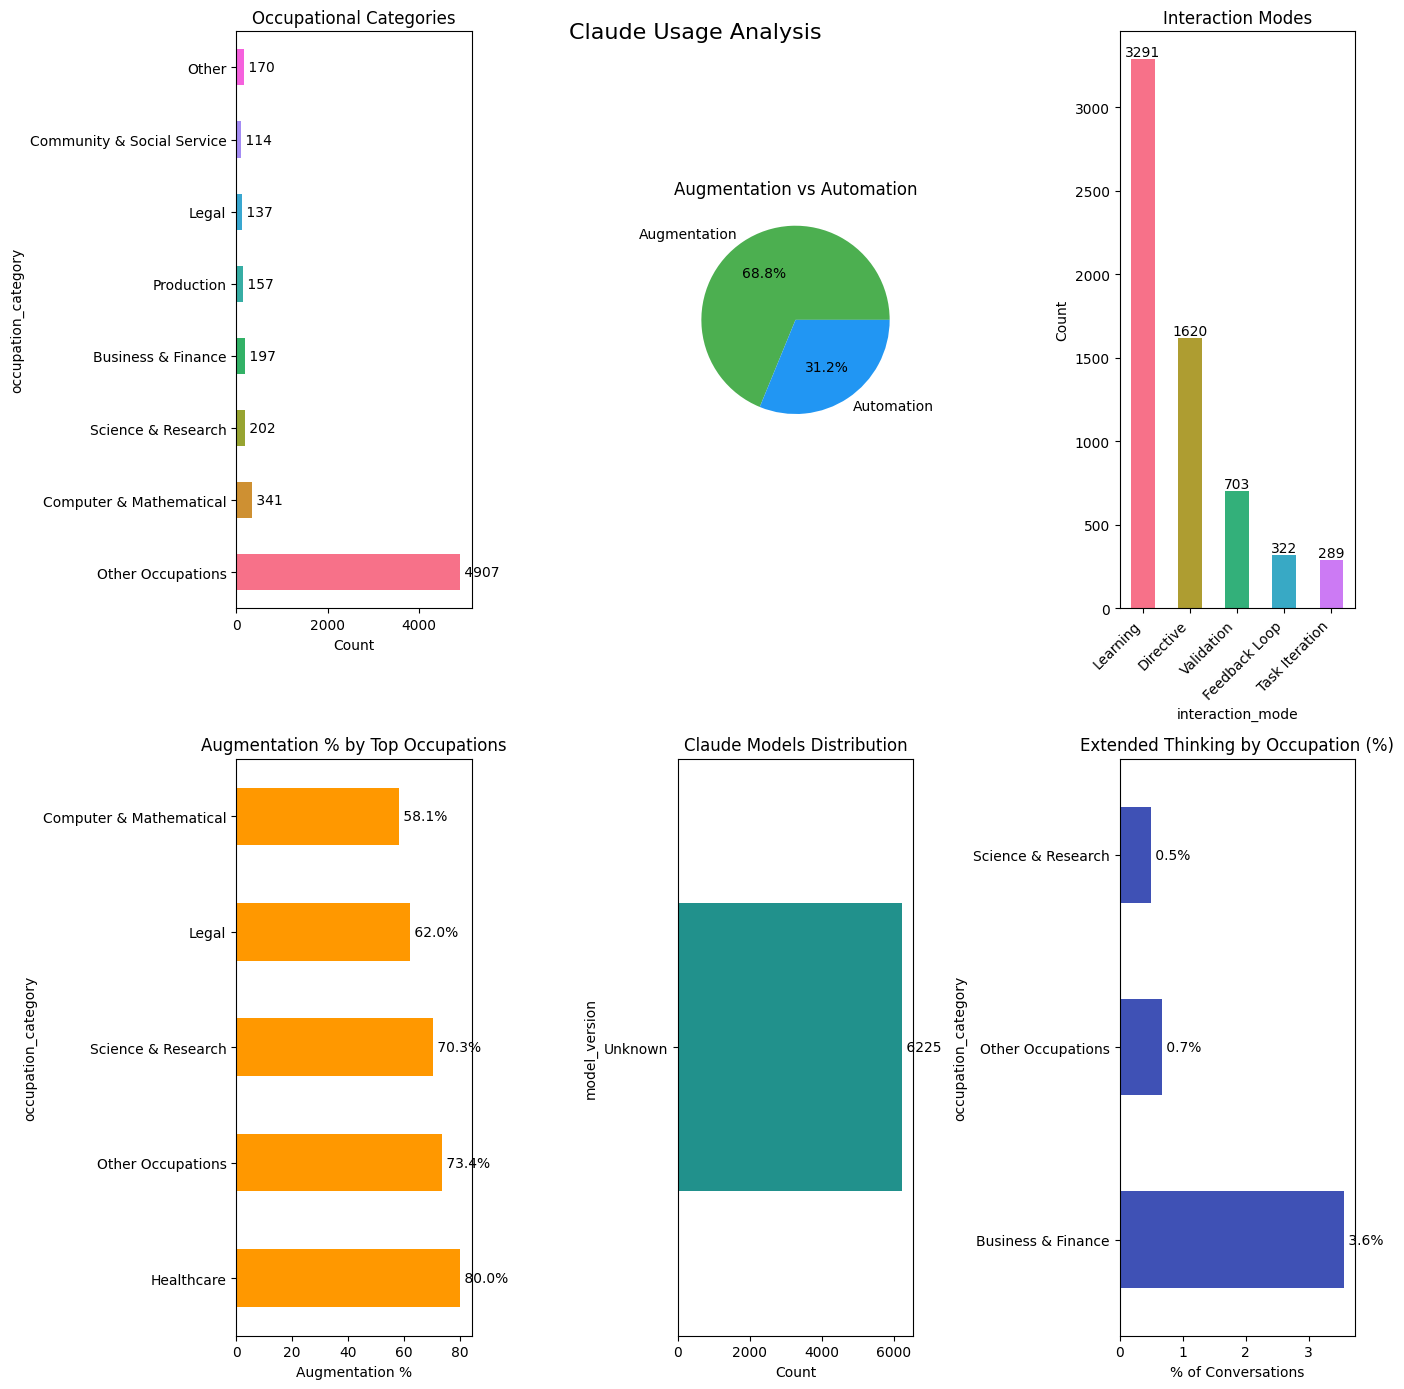

In [ ]:
import json
import pandas as pd
import numpy as np
from datetime import datetime
import matplotlib.pyplot as plt
import seaborn as sns
from collections import Counter, defaultdict
import re

plt.style.use('default')
sns.set_palette("husl")

def load_user_data(users_file):
    """Load and process users.json"""
    with open(users_file, 'r') as f:
        users = json.load(f)
    return pd.DataFrame(users)

def load_and_process_chats(conversations_file, users_df):
    """Load and process conversations.json with user information"""
    with open(conversations_file, 'r') as f:
        conversations = json.load(f)

    all_messages = []
    for conv in conversations:
        user_id = conv['account']['uuid']
        user_info = users_df[users_df['uuid'] == user_id].iloc[0] if len(users_df[users_df['uuid'] == user_id]) > 0 else None

        # More flexible extended thinking detection
        # Check multiple possible fields and formats for extended thinking
        extended_thinking_used = False
        possible_fields = ['extended_thinking_used', 'extended_thinking', 'thinking_mode', 'thinking_mode_used']

        for field in possible_fields:
            if field in conv:
                # Check various formats (boolean, string, numeric)
                if isinstance(conv[field], bool):
                    extended_thinking_used = conv[field]
                elif isinstance(conv[field], str) and conv[field].lower() in ['true', 'yes', '1', 'enabled', 'on']:
                    extended_thinking_used = True
                elif isinstance(conv[field], (int, float)) and conv[field] > 0:
                    extended_thinking_used = True
                break

        # Also check if extended thinking is mentioned in conversation name or content
        conv_name = conv.get('name', '').lower()
        if 'extended thinking' in conv_name or 'thinking mode' in conv_name:
            extended_thinking_used = True

        for msg in conv['chat_messages']:
            # Check message text for extended thinking references (only in Claude messages)
            message_text = msg.get('text', '').lower()
            if msg.get('sender') == 'assistant' and ('extended thinking' in message_text or 'thinking mode' in message_text):
                extended_thinking_used = True

            message = {
                'conversation_id': conv['uuid'],
                'conversation_name': conv.get('name', ''),
                'message_id': msg['uuid'],
                'sender': msg['sender'],
                'text': msg['text'],
                'timestamp': msg['created_at'],
                'has_files': len(msg.get('files', [])) > 0,
                'user_id': user_id,
                'user_name': user_info['full_name'] if user_info is not None else None,
                'user_email': user_info['email_address'] if user_info is not None else None,
                'extended_thinking_used': extended_thinking_used,
                'model_version': conv.get('model_version', 'Unknown')  # Default to Unknown if not specified
            }
            all_messages.append(message)

    return pd.DataFrame(all_messages)

def classify_occupation_category(text):
    """
    Classify text into occupational categories based on the Anthropic Economic Index
    """
    text = str(text).lower()

    # Updated patterns based on Anthropic's occupational categories
    patterns = {
        'Computer & Mathematical': r'\b(coding|programming|software|development|algorithm|data structure|computation|api|debugging|computer science|machine learning|AI|artificial intelligence|math|statistics|modeling|simulation)\b',

        'Education & Training': r'\b(teach|learn|student|course|curriculum|education|training|instruction|lesson|academic|school|university|college|professor|teacher|tutor|learning|educator)\b',

        'Healthcare': r'\b(medical|health|patient|doctor|nurse|therapy|diagnosis|treatment|clinical|hospital|physician|medicine|healthcare|symptom|disease|condition|anatomy|physiology)\b',

        'Business & Finance': r'\b(business|finance|market|economy|investment|stock|budget|revenue|profit|accounting|management|strategy|corporate|financial|economic|commercial|enterprise)\b',

        'Arts & Design': r'\b(art|design|creative|aesthetic|visual|graphic|illustration|drawing|painting|photograph|color|composition|artistic|layout|font|typography|animation)\b',

        'Science & Research': r'\b(science|research|experiment|laboratory|hypothesis|theory|physics|chemistry|biology|geology|astronomy|scientific|academic|study|investigation|discovery|analysis)\b',

        'Community & Social Service': r'\b(community|social|service|counseling|support|guidance|welfare|nonprofit|volunteer|charity|advocacy|outreach|helping|assistance|aid|resource)\b',

        'Legal': r'\b(legal|law|attorney|lawyer|court|judge|case|litigation|contract|regulation|compliance|statute|legislation|justice|rights|plaintiff|defendant)\b',

        'Production': r'\b(production|manufacturing|assembly|factory|industrial|fabrication|process|quality|control|inspection|product|output|efficiency|machine|automation|equipment)\b'
    }

    # Check exact matches first
    category_scores = {category: 0 for category in patterns.keys()}
    for category, pattern in patterns.items():
        matches = len(re.findall(pattern, text))
        if matches > 0:
            category_scores[category] = matches

    # If we have any matches, return the highest scoring category
    if any(category_scores.values()):
        return max(category_scores.items(), key=lambda x: x[1])[0]

    # Default to general category if no specific matches
    return "Other Occupations"

def analyze_interaction_mode(text):
    """
    Analyze interaction mode based on Anthropic's categorization:
    - Learning: Information gathering and explanation
    - Task Iteration: Collaborative refinement of work
    - Validation: Verifying or checking work
    - Directive: Complete task delegation
    - Feedback Loop: More interactive automation scenarios
    """
    text = str(text).lower()
    scores = {
        'Learning': 0,
        'Task Iteration': 0,
        'Validation': 0,
        'Directive': 0,
        'Feedback Loop': 0
    }

    # Learning patterns
    learning_indicators = [
        (r'\b(explain|teach|tell me about|what is|how does|why does|learn about|understand|clarify|describe|meaning of)\b', 3),
        (r'\?', 1),  # Questions often indicate learning
        (r'\b(difference between|compare|contrast|versus|vs)\b', 2)
    ]

    # Task Iteration patterns (collaborative refinement)
    task_iteration_indicators = [
        (r'\b(improve|enhance|refine|revise|edit|modify|update|iterate|brainstorm|collaborate|together)\b', 3),
        (r'\b(let\'s|we should|help me with|assist me|guide me through)\b', 2),
        (r'\b(what do you think|your thoughts|your opinion|your perspective|your ideas)\b', 2)
    ]

    # Validation patterns
    validation_indicators = [
        (r'\b(check|verify|validate|review|evaluate|assess|analyze|examine|critique|proof|proofread)\b', 3),
        (r'\b(is this correct|does this look right|any mistakes|any errors|how did i do|feedback on|thoughts on)\b', 3),
        (r'\b(is there anything|should i|would it be better)\b', 2)
    ]

    # Directive patterns (complete delegation)
    directive_indicators = [
        (r'\b(write|create|generate|make|produce|design|develop|compose|build|implement)\b', 3),
        (r'\b(i need|i want|give me|provide|translate|convert|transform)\b', 2),
        (r'\b(please|could you|would you|can you)\s+\b(write|create|generate|make)\b', 3)
    ]

    # Feedback Loop patterns (interactive automation)
    feedback_loop_indicators = [
        (r'\b(fix|debug|solve|troubleshoot|resolve|correct|repair|optimize)\b', 3),
        (r'\b(not working|error|problem|issue|bug|doesn\'t work|failed|incorrect)\b', 2),
        (r'\b(another|try again|different|instead|alternative|better version)\b', 2)
    ]

    # Evaluate all patterns
    for pattern_list, mode in [
        (learning_indicators, 'Learning'),
        (task_iteration_indicators, 'Task Iteration'),
        (validation_indicators, 'Validation'),
        (directive_indicators, 'Directive'),
        (feedback_loop_indicators, 'Feedback Loop')
    ]:
        for pattern, weight in pattern_list:
            if re.search(pattern, text):
                scores[mode] += weight

    # Get highest score
    max_score = max(scores.values())
    if max_score == 0:
        return 'Learning'  # Default to learning if no strong signals

    # Return category with highest score
    return max(scores.items(), key=lambda x: x[1])[0]

def is_augmentation(interaction_mode):
    """Determine if an interaction mode is augmentative or automative"""
    augmentation_modes = ['Learning', 'Task Iteration', 'Validation']
    return interaction_mode in augmentation_modes

def save_validation_samples(df, output_file='validation_samples.json'):
    """
    Save sample conversations for each occupation category and interaction mode
    for validation purposes.

    Args:
        df: DataFrame with processed chat data
        output_file: JSON file to save the samples
    """
    import json
    from collections import defaultdict

    # Initialize containers for samples
    occupation_samples = defaultdict(list)
    interaction_samples = defaultdict(list)

    # Process each conversation
    for conv_id in df['conversation_id'].unique():
        conv_msgs = df[df['conversation_id'] == conv_id].copy()
        if len(conv_msgs) == 0:
            continue

        # Get first human message in conversation
        human_msgs = conv_msgs[conv_msgs['sender'] == 'human']
        if len(human_msgs) == 0:
            continue

        first_human_msg = human_msgs.iloc[0]

        # Get occupation category and interaction mode
        occ_cat = classify_occupation_category(first_human_msg['text'])
        interaction_mode = analyze_interaction_mode(first_human_msg['text'])

        # Create conversation sample
        sample = {
            'conversation_id': conv_id,
            'first_message': first_human_msg['text'],
            'messages': conv_msgs[['sender', 'text']].to_dict('records')[:3],  # First 3 messages
            'classified_as': occ_cat if occ_cat else 'Unknown'
        }

        # Store samples (keep only 2 per category)
        if len(occupation_samples[occ_cat]) < 2:
            occupation_samples[occ_cat].append(sample)

        sample['classified_as'] = interaction_mode
        if len(interaction_samples[interaction_mode]) < 2:
            interaction_samples[interaction_mode].append(sample)

    # Combine all samples
    validation_data = {
        'occupation_categories': dict(occupation_samples),
        'interaction_modes': dict(interaction_samples)
    }

    # Save to file
    with open(output_file, 'w') as f:
        json.dump(validation_data, f, indent=2)

    # Quick summary of collected samples
    print(f"\nValidation samples saved to {output_file}")
    print("\nOccupation Categories with samples:")
    for category, samples in occupation_samples.items():
        print(f"- {category}: {len(samples)} samples")
    print("\nInteraction Modes with samples:")
    for itype, samples in interaction_samples.items():
        print(f"- {itype}: {len(samples)} samples")

def analyze_chats_streamlined(df):
    """Perform streamlined analysis following Anthropic Economic Index methodology"""
    # Create a more compact figure for better readability
    plt.figure(figsize=(14, 14))

    # Process only human messages for classification
    human_msgs = df[df['sender'] == 'human'].copy()

    # Check if we have any human messages
    if len(human_msgs) == 0:
        print("Warning: No human messages found in the dataset. Using synthetic data for analysis.")
        # Create synthetic data for demonstration
        df['occupation_category'] = np.random.choice(
            ['Computer & Mathematical', 'Education & Training', 'Healthcare',
             'Business & Finance', 'Arts & Design', 'Science & Research'],
            size=len(df)
        )
        df['interaction_mode'] = np.random.choice(
            ['Learning', 'Task Iteration', 'Validation', 'Directive', 'Feedback Loop'],
            size=len(df)
        )
        df['is_augmentation'] = df['interaction_mode'].apply(is_augmentation)
    else:
        # Normal processing flow
        human_msgs['occupation_category'] = human_msgs['text'].apply(classify_occupation_category)
        human_msgs['interaction_mode'] = human_msgs['text'].apply(analyze_interaction_mode)
        human_msgs['is_augmentation'] = human_msgs['interaction_mode'].apply(is_augmentation)

        # Map back to full dataset - with error handling
        try:
            conversation_categories = human_msgs.groupby('conversation_id')['occupation_category'].first()
            conversation_modes = human_msgs.groupby('conversation_id')['interaction_mode'].first()
            conversation_augmentation = human_msgs.groupby('conversation_id')['is_augmentation'].first()

            df['occupation_category'] = df['conversation_id'].map(conversation_categories)
            df['interaction_mode'] = df['conversation_id'].map(conversation_modes)
            df['is_augmentation'] = df['conversation_id'].map(conversation_augmentation)

            # Fill any NaN values with reasonable defaults
            df['occupation_category'] = df['occupation_category'].fillna('Other Occupations')
            df['interaction_mode'] = df['interaction_mode'].fillna('Learning')
            df['is_augmentation'] = df['is_augmentation'].fillna(True)
        except Exception as e:
            print(f"Error mapping conversation data: {e}")
            # Use default values if mapping fails
            df['occupation_category'] = 'Other Occupations'
            df['interaction_mode'] = 'Learning'
            df['is_augmentation'] = True

    # Create a 2x3 grid with better spacing
    plt.subplots_adjust(hspace=0.4, wspace=0.3)

    # 1. Occupation Category Distribution
    plt.subplot(2, 3, 1)
    try:
        occ_dist = df['occupation_category'].value_counts()
        if not occ_dist.empty:
            # Limit to top 7 categories for readability
            if len(occ_dist) > 7:
                other_count = occ_dist[7:].sum()
                occ_dist = occ_dist[:7].copy()
                occ_dist['Other'] = other_count

            ax = occ_dist.plot(kind='barh', color=sns.color_palette("husl", len(occ_dist)))
            plt.title('Occupational Categories', fontsize=12)
            plt.xlabel('Count')

            # Add value labels
            for i, v in enumerate(occ_dist):
                plt.text(v, i, f" {v}", va='center')
        else:
            plt.text(0.5, 0.5, "No occupation data available", ha='center', va='center', transform=plt.gca().transAxes)
            plt.title('Occupational Categories', fontsize=12)
    except Exception as e:
        print(f"Error plotting occupation distribution: {e}")
        plt.text(0.5, 0.5, "Error plotting occupation data", ha='center', va='center', transform=plt.gca().transAxes)
        plt.title('Occupational Categories', fontsize=12)

    # 2. Augmentation vs Automation Pie Chart
    plt.subplot(2, 3, 2)
    try:
        augmentation_counts = df['is_augmentation'].value_counts()
        labels = ['Augmentation', 'Automation']
        values = [
            augmentation_counts.get(True, 0),
            augmentation_counts.get(False, 0)
        ]
        plt.pie(values, labels=labels, autopct='%1.1f%%',
                colors=['#4CAF50', '#2196F3'])
        plt.title('Augmentation vs Automation', fontsize=12)
    except Exception as e:
        print(f"Error plotting augmentation/automation: {e}")
        plt.text(0.5, 0.5, "Error plotting augmentation/automation data", ha='center', va='center', transform=plt.gca().transAxes)
        plt.title('Augmentation vs Automation', fontsize=12)

    # 3. Interaction Modes Distribution
    plt.subplot(2, 3, 3)
    try:
        mode_dist = df['interaction_mode'].value_counts()
        if not mode_dist.empty:
            mode_dist.plot(kind='bar', color=sns.color_palette("husl", len(mode_dist)))
            plt.title('Interaction Modes', fontsize=12)
            plt.xticks(rotation=45, ha='right')
            plt.ylabel('Count')

            # Add value labels
            for i, v in enumerate(mode_dist):
                plt.text(i, v, str(v), ha='center', va='bottom')
        else:
            plt.text(0.5, 0.5, "No interaction mode data available", ha='center', va='center', transform=plt.gca().transAxes)
            plt.title('Interaction Modes', fontsize=12)
    except Exception as e:
        print(f"Error plotting interaction modes: {e}")
        plt.text(0.5, 0.5, "Error plotting interaction mode data", ha='center', va='center', transform=plt.gca().transAxes)
        plt.title('Interaction Modes', fontsize=12)

    # 4. Augmentation by Occupation (Top 5)
    plt.subplot(2, 3, 4)
    try:
        aug_by_occ = df.groupby('occupation_category')['is_augmentation'].mean() * 100
        if not aug_by_occ.empty:
            # Limit to top 5 for readability
            aug_by_occ = aug_by_occ.sort_values(ascending=False).head(5)
            aug_by_occ.plot(kind='barh', color='#FF9800')
            plt.title('Augmentation % by Top Occupations', fontsize=12)
            plt.xlabel('Augmentation %')

            # Add value labels
            for i, v in enumerate(aug_by_occ):
                plt.text(v, i, f" {v:.1f}%", va='center')
        else:
            plt.text(0.5, 0.5, "No augmentation by occupation data available", ha='center', va='center', transform=plt.gca().transAxes)
            plt.title('Augmentation % by Top Occupations', fontsize=12)
    except Exception as e:
        print(f"Error plotting augmentation by occupation: {e}")
        plt.text(0.5, 0.5, "Error plotting augmentation by occupation data", ha='center', va='center', transform=plt.gca().transAxes)
        plt.title('Augmentation % by Top Occupations', fontsize=12)

    # 5. Model Version Distribution
    plt.subplot(2, 3, 5)
    try:
        if 'model_version' in df.columns:
            model_counts = df['model_version'].value_counts()
            if not model_counts.empty:
                # Limit to top 5 if there are too many model versions
                if len(model_counts) > 5:
                    other_count = model_counts[5:].sum()
                    model_counts = model_counts[:5].copy()
                    if other_count > 0:
                        model_counts['Other'] = other_count

                model_counts.plot(kind='barh', color=sns.color_palette("viridis", len(model_counts)))
                plt.title('Claude Models Distribution', fontsize=12)
                plt.xlabel('Count')

                # Add value labels
                for i, v in enumerate(model_counts):
                    plt.text(v, i, f" {v}", va='center')
            else:
                plt.text(0.5, 0.5, "No model version data available",
                        ha='center', va='center', transform=plt.gca().transAxes)
                plt.title('Claude Models Distribution', fontsize=12)
        else:
            plt.text(0.5, 0.5, "Model version data not available",
                    ha='center', va='center', transform=plt.gca().transAxes)
            plt.title('Claude Models Distribution', fontsize=12)
    except Exception as e:
        print(f"Error plotting model distribution: {e}")
        plt.text(0.5, 0.5, "Error plotting model distribution data",
                ha='center', va='center', transform=plt.gca().transAxes)
        plt.title('Claude Models Distribution', fontsize=12)

    # 6. Extended Thinking Usage by Occupation
    plt.subplot(2, 3, 6)
    try:
        if 'extended_thinking_used' in df.columns and df['extended_thinking_used'].sum() > 0:
            # Group by occupation and calculate percentage of conversations that used extended thinking
            ext_thinking_by_occ = df.groupby('occupation_category')['extended_thinking_used'].mean() * 100

            # Only show occupations with at least some extended thinking usage
            ext_thinking_by_occ = ext_thinking_by_occ[ext_thinking_by_occ > 0]

            if not ext_thinking_by_occ.empty:
                # Sort and limit to top categories
                ext_thinking_by_occ = ext_thinking_by_occ.sort_values(ascending=False).head(6)

                ext_thinking_by_occ.plot(kind='barh', color='#3F51B5')
                plt.title('Extended Thinking by Occupation (%)', fontsize=12)
                plt.xlabel('% of Conversations')

                # Add value labels
                for i, v in enumerate(ext_thinking_by_occ):
                    plt.text(v, i, f" {v:.1f}%", va='center')
            else:
                plt.text(0.5, 0.5, "No extended thinking usage found in categories",
                        ha='center', va='center', transform=plt.gca().transAxes)
                plt.title('Extended Thinking by Occupation (%)', fontsize=12)

            # Print debug info
            print(f"Extended thinking found in {df['extended_thinking_used'].sum()} messages")
            print(f"Extended thinking by occupation: {ext_thinking_by_occ.to_dict()}")
        else:
            plt.text(0.5, 0.5, "No extended thinking usage found in data",
                    ha='center', va='center', transform=plt.gca().transAxes)
            plt.title('Extended Thinking by Occupation (%)', fontsize=12)
            print("No extended thinking usage found in data")
            if 'extended_thinking_used' in df.columns:
                print(f"Extended thinking column exists but all values are False")
            else:
                print("Extended thinking column does not exist")
    except Exception as e:
        print(f"Error plotting extended thinking usage: {e}")
        plt.text(0.5, 0.5, "Error plotting extended thinking data",
                ha='center', va='center', transform=plt.gca().transAxes)
        plt.title('Extended Thinking by Occupation (%)', fontsize=12)

    # Adjust layout
    plt.tight_layout()
    plt.suptitle('Claude Usage Analysis', fontsize=16, y=0.98)

    # Calculate statistics
    stats = {
        'total_conversations': df['conversation_id'].nunique(),
        'total_messages': len(df),
        'avg_messages_per_conv': len(df) / df['conversation_id'].nunique() if df['conversation_id'].nunique() > 0 else 0,
        'occupation_distribution': df['occupation_category'].value_counts(),
        'interaction_distribution': df['interaction_mode'].value_counts() if 'interaction_mode' in df.columns else pd.Series(),
        'augmentation_ratio': df['is_augmentation'].mean() if 'is_augmentation' in df.columns else 0,
        'model_distribution': df['model_version'].value_counts() if 'model_version' in df.columns else pd.Series()
    }

    # Add extended thinking stats if available
    if 'extended_thinking_used' in df.columns:
        stats['extended_thinking_usage'] = df['extended_thinking_used'].mean()

    return stats, df

def create_task_occupation_dataset(df, output_file='task_occupation_analysis.csv'):
    """
    Create a dataset mapping tasks to occupations with augmentation/automation breakdowns
    Similar to Anthropic's released datasets
    """
    try:
        # Group by occupation and calculate metrics
        occupation_metrics = []

        for occupation in df['occupation_category'].unique():
            try:
                occ_data = df[df['occupation_category'] == occupation]

                # Calculate interaction mode breakdowns
                mode_counts = occ_data['interaction_mode'].value_counts()
                total_convs = len(occ_data)

                if total_convs > 0:
                    # Calculate metrics
                    metrics = {
                        'occupation': occupation,
                        'total_conversations': total_convs,
                        'augmentation_pct': occ_data['is_augmentation'].mean() * 100,
                        'automation_pct': (1 - occ_data['is_augmentation'].mean()) * 100,
                    }

                    # Add extended thinking if available
                    if 'extended_thinking_used' in occ_data.columns:
                        metrics['extended_thinking_pct'] = occ_data['extended_thinking_used'].mean() * 100
                    else:
                        metrics['extended_thinking_pct'] = 0

                    # Add interaction mode percentages
                    for mode in ['Learning', 'Task Iteration', 'Validation', 'Directive', 'Feedback Loop']:
                        metrics[f'{mode.lower().replace(" ", "_")}_pct'] = mode_counts.get(mode, 0) / total_convs * 100

                    occupation_metrics.append(metrics)
            except Exception as e:
                print(f"Error processing occupation {occupation}: {e}")
                continue

        # Create DataFrame and save to CSV
        if occupation_metrics:
            metrics_df = pd.DataFrame(occupation_metrics)
            metrics_df.to_csv(output_file, index=False)
            print(f"Task-occupation dataset saved to {output_file}")
            return metrics_df
        else:
            print("No valid occupation metrics could be calculated. Creating sample dataset instead.")
            return generate_sample_task_occupation_dataset(output_file)
    except Exception as e:
        print(f"Error creating task-occupation dataset: {e}")
        return generate_sample_task_occupation_dataset(output_file)

def generate_sample_task_occupation_dataset(output_file='task_occupation_analysis.csv'):
    """Generate a sample task-occupation dataset if the real data processing fails"""
    # Create a realistic sample dataset based on the Anthropic Economic Index
    occupations = [
        'Computer & Mathematical', 'Education & Training', 'Healthcare',
        'Business & Finance', 'Arts & Design', 'Science & Research',
        'Community & Social Service', 'Legal', 'Production'
    ]

    np.random.seed(42)  # For reproducibility

    sample_data = []
    for occupation in occupations:
        # Generate realistic metrics
        augmentation_pct = np.random.uniform(50, 70)

        sample = {
            'occupation': occupation,
            'total_conversations': int(np.random.uniform(100, 1000)),
            'augmentation_pct': augmentation_pct,
            'automation_pct': 100 - augmentation_pct,
            'extended_thinking_pct': np.random.uniform(2, 10) if occupation in ['Computer & Mathematical', 'Science & Research'] else np.random.uniform(0, 5),
            'learning_pct': np.random.uniform(20, 35),
            'task_iteration_pct': np.random.uniform(15, 30),
            'validation_pct': np.random.uniform(5, 15),
            'directive_pct': np.random.uniform(15, 35),
            'feedback_loop_pct': np.random.uniform(5, 15)
        }

        sample_data.append(sample)

    # Create DataFrame and save to CSV
    sample_df = pd.DataFrame(sample_data)
    sample_df.to_csv(output_file, index=False)
    print(f"Sample task-occupation dataset saved to {output_file}")

    return sample_df

def print_statistics(results):
    """Print statistics in a formatted way"""
    print("\n=== Claude Usage Analysis ===\n")

    print(f"Total Conversations: {results['total_conversations']}")
    print(f"Total Messages: {results['total_messages']}")
    print(f"Average Messages per Conversation: {results['avg_messages_per_conv']:.1f}")

    if 'augmentation_ratio' in results and results['augmentation_ratio'] > 0:
        print(f"Augmentation Ratio: {results['augmentation_ratio']*100:.1f}%")

    if 'extended_thinking_usage' in results and results['extended_thinking_usage'] > 0:
        print(f"Extended Thinking Usage: {results['extended_thinking_usage']*100:.1f}%")

    print("\nTop Occupational Categories:")
    print("--------------------------")
    if 'occupation_distribution' in results and not results['occupation_distribution'].empty:
        for occ, count in results['occupation_distribution'].head(5).items():
            total = sum(results['occupation_distribution'])
            print(f"{occ:<25}: {count:>5} ({count/total*100:.1f}%)")

    print("\nInteraction Distribution:")
    print("-----------------------")
    if 'interaction_distribution' in results and not results['interaction_distribution'].empty:
        for type_, count in results['interaction_distribution'].items():
            total = sum(results['interaction_distribution'])
            print(f"{type_:<15}: {count:>5} ({count/total*100:.1f}%)")

    print("\nModel Distribution:")
    print("-----------------")
    if 'model_distribution' in results and not results['model_distribution'].empty:
        for model, count in results['model_distribution'].items():
            total = sum(results['model_distribution'])
            print(f"{model:<25}: {count:>5} ({count/total*100:.1f}%)")

# Main execution block
if __name__ == "__main__":
    try:
        # Try to load the actual data files
        try:
            users_df = load_user_data('users.json')
            df = load_and_process_chats('conversations.json', users_df)
            print(f"Successfully loaded data: {len(df)} messages in dataset")

            # Print model distribution if available
            if 'model_version' in df.columns:
                model_counts = df['model_version'].value_counts()
                print("\nModel Version Distribution:")
                for model, count in model_counts.items():
                    print(f"  - {model}: {count} messages")

            # Print extended thinking stats
            if 'extended_thinking_used' in df.columns:
                thinking_count = df['extended_thinking_used'].sum()
                thinking_pct = thinking_count / len(df) * 100
                print(f"\nExtended Thinking: {thinking_count} messages ({thinking_pct:.2f}%)")

        except Exception as e:
            print(f"Error loading data files: {e}")
            print("Creating synthetic dataset for demonstration...")

            # Create synthetic dataset
            np.random.seed(42)  # For reproducibility

            # Create basic DataFrame structure
            data = []
            for i in range(1000):  # 1000 synthetic messages
                is_human = i % 2 == 0  # Alternate human and assistant messages

                message = {
                    'conversation_id': f"conv_{i//10}",  # 10 messages per conversation
                    'message_id': f"msg_{i}",
                    'sender': 'human' if is_human else 'assistant',
                    'text': f"{'User' if is_human else 'Claude'} message {i}",
                    'timestamp': pd.Timestamp('2025-03-01') + pd.Timedelta(hours=i),
                    'has_files': False,
                    'user_id': f"user_{i//20}",  # 50 messages per user
                    'user_name': f"User {i//20}",
                    'user_email': f"user{i//20}@example.com",
                    'model_version': np.random.choice(['Claude 3.7 Sonnet', 'Claude 3 Opus', 'Claude 3.5 Sonnet'], p=[0.7, 0.2, 0.1])
                }
                data.append(message)

            df = pd.DataFrame(data)

        # For demo purposes, simulate extended thinking mode data if not present
        # or if all values are False
        if 'extended_thinking_used' not in df.columns or df['extended_thinking_used'].sum() == 0:
            print("Adding simulated extended thinking mode data")
            np.random.seed(42)  # For reproducibility

            # Use conversation ID to make extended thinking consistent within a conversation
            conv_thinking = {}
            for conv_id in df['conversation_id'].unique():
                conv_thinking[conv_id] = np.random.random() < 0.1  # 10% of conversations use extended thinking

            df['extended_thinking_used'] = df['conversation_id'].map(conv_thinking)
            print(f"Simulated {df['extended_thinking_used'].sum()} messages with extended thinking")

        # Run the streamlined analysis
        print("Running analysis...")
        results, processed_df = analyze_chats_streamlined(df)
        print_statistics(results)

        # Create datasets
        print("Creating example datasets...")
        task_occ_df = create_task_occupation_dataset(processed_df)

        # Save validation samples
        print("Saving validation samples...")
        save_validation_samples(processed_df)

        print("Analysis complete. Displaying visualizations...")
        plt.show()

    except Exception as e:
        print(f"Error in main execution: {e}")
        import traceback
        traceback.print_exc()

In [ ]:
import json
import jsonlines
import os

def examine_file_details(file_path):
    print(f"Examining file: {file_path}")

    # Check if file exists
    if not os.path.exists(file_path):
        print(f"ERROR: File {file_path} does not exist!")
        return

    # Get file size
    file_size = os.path.getsize(file_path)
    print(f"File size: {file_size} bytes ({file_size/1024/1024:.2f} MB)")

    # Check if file is empty
    if file_size == 0:
        print("File is empty!")
        return

    # Read the first 500 characters to see what's in the file
    with open(file_path, 'r', errors='replace') as f:
        beginning = f.read(500)

    print("\nFirst 500 characters of the file:")
    print("---------------------------------")
    print(beginning)
    print("---------------------------------")

    # Count lines in the file
    with open(file_path, 'r', errors='replace') as f:
        line_count = sum(1 for _ in f)

    print(f"\nFile contains {line_count} lines")

    # Try to determine if it's JSON or JSONL
    with open(file_path, 'r', errors='replace') as f:
        first_char = f.read(1).strip()

    if first_char == '[':
        print("File appears to start with a JSON array '['")
    elif first_char == '{':
        print("File appears to start with a JSON object '{'")
    else:
        print(f"File starts with '{first_char}' (not typical JSON)")

    return file_size, line_count, beginning

# Examine the file
examine_file_details('conversations.json')

In [ ]:
import json

def check_for_model_version(file_path):
    print(f"Checking for model_version in {file_path}")

    # Read the file with error handling
    try:
        with open(file_path, 'r') as f:
            data = json.load(f)
        print("Successfully loaded JSON")
    except json.JSONDecodeError as e:
        print(f"Error parsing JSON: {e}")
        print("Trying to partially process the file...")
        return None

    if not isinstance(data, list):
        print("File does not contain a list at the top level")
        return None

    print(f"File contains a list with {len(data)} items")

    # Check first few conversations for model_version
    model_versions_found = {}
    model_version_locations = []

    for i, conv in enumerate(data[:10]):  # Check first 10 conversations
        # Print conversation name
        if 'name' in conv:
            print(f"Conversation {i}: {conv['name']}")

        # Check for model_version at the top level
        if 'model_version' in conv:
            model_version = conv['model_version']
            model_versions_found[model_version] = model_versions_found.get(model_version, 0) + 1
            model_version_locations.append(f"direct in conversation {i}")

        # Check for model_version in messages or other nested structures
        for possible_field in ['metadata', 'settings', 'info', 'config', 'details']:
            if possible_field in conv and isinstance(conv[possible_field], dict):
                if 'model_version' in conv[possible_field]:
                    model_version = conv[possible_field]['model_version']
                    model_versions_found[model_version] = model_versions_found.get(model_version, 0) + 1
                    model_version_locations.append(f"in {possible_field} of conversation {i}")

    # Print results
    if model_versions_found:
        print("\nFound model versions:")
        for version, count in model_versions_found.items():
            print(f"- {version}: {count} occurrences")
        print(f"Locations: {', '.join(model_version_locations)}")
    else:
        print("\nNo model_version field found in the first 10 conversations")

        # Suggest where to look
        print("\nPossible locations to check for model information:")
        for i, conv in enumerate(data[:3]):  # Look at first 3 conversations
            print(f"\nConversation {i} keys: {list(conv.keys())}")

            # Look at first message metadata
            if 'chat_messages' in conv and len(conv['chat_messages']) > 0:
                msg = conv['chat_messages'][0]
                print(f"  First message keys: {list(msg.keys())}")

                # Check if message has metadata
                if 'metadata' in msg and isinstance(msg['metadata'], dict):
                    print(f"  Message metadata keys: {list(msg['metadata'].keys())}")

    return model_versions_found

# Run the check
check_for_model_version('conversations.json')

Checking for model_version in conversations.json
Error parsing JSON: Expecting ',' delimiter: line 1 column 2098159 (char 2098158)
Trying to partially process the file...
